In [ ]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow.keras.metrics
from tensorflow.keras.utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.options.display.max_columns
pd.options.display.max_rows
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!git clone https://github.com/Jmazo25/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
df = pd.read_csv("/content/Monografia/train.csv")

In [ ]:
df.dropna(axis = 0, how ='any',inplace=True)
df.reset_index(inplace=True)
df.shape

(27480, 5)

In [ ]:
df.head(3)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,2,088c60f138,my boss is bullying me...,bullying me,negative


#Eiliminación de stop words

In [ ]:
def clean_text(t):
  tl = []
  t = t.lower().split()
  for i in t:
    if i not in stopwords.words('english'):
      tl.append(i)
  return " ".join(tl)

In [ ]:
#Limpiar expresiones Regulares
df['text'] = df['text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#Remover stopwords
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [ ]:
##Limpiar expresiones Regulares
df['selected_text'] = df['selected_text'].apply((lambda x:re.sub('@[^\s]+','',x)))
df['selected_text'] = df['selected_text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#Remover StopWords
df['selected_text'] = df['selected_text'].apply(lambda x: clean_text(x))

In [ ]:
df.head(5)

,index,textID,text,selected_text,sentiment
0,0,cb774db0d1,i`d responded going,i`d responded going,neutral
1,1,549e992a42,sooo sad miss san diego,sooo sad,negative
2,2,088c60f138,boss bullying,bullying,negative
3,3,9642c003ef,interview leave alone,leave alone,negative
4,4,358bd9e861,sons couldn`t put releases already bought,sons,negative


Se procede a buscar el tweet con mayor longitud en términos de palabras

In [ ]:
dim_tw = df['text'].str.split().str.len()

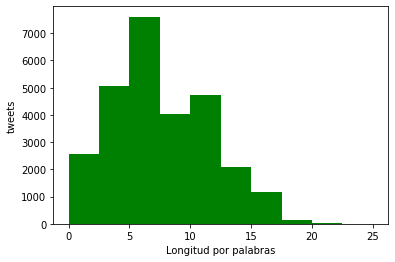

In [ ]:
fig, ax1 = plt.subplots()
plt.hist(dim_tw,color='green')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("tweets")
plt.show()

In [ ]:
dim_tw.describe()

count    27480.000000
mean         7.416230
std          3.983212
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         25.000000
Name: text, dtype: float64

Funciones que permiten extraer los índices inicial y final del texto seleccionado del tweet

In [ ]:
def ind(t1,t2):
    l = []
    ini = int
    fin = int
    t1 = t1.lower().split()
    t2 = t2.lower().split()
    for i in t2:
        for ind,j in enumerate(t1):
          if i == j:
            l.append(ind)
    if l != []:
        ini=(l[0])
        fin=(l[-1])
    else:
        ini = 0
        fin = 0
    return ini

In [ ]:
def ind2(t1,t2):
  l = []
  ini = int
  fin = int
  t1 = t1.lower().split()
  t2 = t2.lower().split()
  for i in t2:
    for ind,j in enumerate(t1):
      if i == j:
        l.append(ind)
  if l != []:
    ini=(l[0])
    fin=(ini+len(t2)-1)
  else:
    ini = 0
    fin = 0
  return fin

test de las funciones

In [ ]:
f= ind('I`d have responded, if I were going','I`d have responded, if I were going')
f

0

In [ ]:
df2 = df[['text','selected_text']] 

In [ ]:
df2

,text,selected_text
0,i`d responded going,i`d responded going
1,sooo sad miss san diego,sooo sad
2,boss bullying,bullying
3,interview leave alone,leave alone
4,sons couldn`t put releases already bought,sons
...,...,...
27475,wish could come see u denver husband lost job ...,lost
27476,i`ve wondered rake client made clear net don`t...,don`t force
27477,yay good enjoy break probably need hectic week...,yay good
27478,worth,worth


In [ ]:
y_true_i = df2.apply(lambda x: ind(x['text'],x['selected_text']),axis=1)

In [ ]:
y_true_f = df2.apply(lambda x: ind2(x['text'],x['selected_text']),axis=1)

In [ ]:
df2['start_w'] = y_true_i
df2['end_w'] = y_true_f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in range(y_true_f.shape[0]):
  if type(y_true_f[i]) != type(y_true_f[0]):
    print(type(y_true_f[i]))

#Obteniendo tamaño del tweet

In [ ]:
def leng(x):
  x = x.lower().split()
  a = len(x)
  return a

In [ ]:
long = df2.apply(lambda x: leng(x['text']),axis=1)

In [ ]:
long = np.array(long)

In [ ]:
df2.head(3)

,text,selected_text,start_w,end_w
0,i`d responded going,i`d responded going,0,2
1,sooo sad miss san diego,sooo sad,0,1
2,boss bullying,bullying,1,1


In [ ]:
y_true_i = y_true_i.to_numpy(dtype='float32')

In [ ]:
y_true_f = y_true_f.to_numpy(dtype='float32')

#Codificación del sentimiento para ser una entrada válida en el modelo


In [ ]:
labels1 = {"sentiment": {"neutral":0,"positive":1,"negative":2}}

In [ ]:
df = df.replace(labels1)
labels = df['sentiment']
#labels
#labels = to_categorical(labels)

In [ ]:
labels

0        0
1        2
2        2
3        2
4        2
        ..
27475    2
27476    2
27477    1
27478    1
27479    0
Name: sentiment, Length: 27480, dtype: int64

#Tokenización

In [ ]:
text = list(df['text'].values)

In [ ]:
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28612 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=max(dim_tw))

#Split de la data

In [ ]:
X_train,x_test,Y_train_i,y_test_i,Y_train_f,y_test_f,long_train,long_test,Labels_train,labels_test, TS_train, ts_test = train_test_split(data,y_true_i,y_true_f,long,labels,df['text'], test_size=0.15, random_state=42)
x_train,x_val,y_train_i,y_val_i,y_train_f,y_val_f,l_train,l_val,labels_train,labels_val = train_test_split(X_train,Y_train_i,Y_train_f,long_train,Labels_train, test_size=0.1, random_state=42)
x_train.shape, y_train_i.shape,y_train_f.shape,x_val.shape, y_val_i.shape,y_val_f.shape, x_test.shape, y_test_i.shape,y_test_f.shape,

((21022, 25),
 (21022,),
 (21022,),
 (2336, 25),
 (2336,),
 (2336,),
 (4122, 25),
 (4122,),
 (4122,))

In [ ]:
l_train.shape ,long_test.shape, l_val.shape

((21022,), (4122,), (2336,))

In [ ]:
type(y_train_i)

numpy.ndarray

#Capa de Embeding

Debido a que pesa más de 400 Mb se pondrá el enlace donde se puede descargar para uso del lector, se debe establecer la variable Path con la ruta donde el archivo esté puesto.
https://nlp.stanford.edu/projects/glove/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((tokenizer.num_words + 1, 100))
for i in range(1,tokenizer.num_words):
  word = tokenizer.index_word[i]
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
  else:
      embedding_matrix[i] = embeddings_index.get('unk')

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(tokenizer.num_words + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=25,
                            trainable=False,
                            mask_zero=True)

#Definición de métricas

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Creación del modelo

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPooling1D, LSTM, RepeatVector, Concatenate
from tensorflow.keras import Model,Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras import callbacks
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError, MeanSquaredError

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow.keras.backend as K
tf.config.list_physical_devices('GPU')

[]

Modelo con dos salidas

In [ ]:
sequence_input = Input(shape=(25,), dtype='int32')
sentiment = Input(shape=(1,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input)

xs = Embedding(3,20)(sentiment)
xs = Flatten()(xs)
xs = RepeatVector(25)(xs)

x = Concatenate(axis=-1)([xs,embedded_sequences])

x1 = Bidirectional(LSTM(50,return_sequences=True))(x)
x1 = Bidirectional(LSTM(50,return_sequences=False))(x1)
x1 = Dense(128, activation='relu')(x1)

salida1 = Dense(1)(x1)
salida2 = Dense(1)(x1)


model = Model(inputs=[sequence_input,sentiment], outputs=[salida1,salida2])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(loss=['mse','mse'], optimizer=optimizer,metrics=[MeanAbsoluteError(),MeanSquaredError()])

"""
model.fit([x_train,labels_train], [y_train_i,y_train_f], validation_data=([x_val,labels_val], [y_val_i,y_val_f]),
          epochs=15, batch_size=32,verbose=1)

loss, loss1, loss2, MAE1,MSE1,MAE2,MSE2 = model.evaluate([x_test,labels_test],[y_test_i,y_test_f], verbose=0,batch_size=128)
print("Loss: {}".format(loss))
print("MAE 1: {} MAE 2: {}".format(MAE1,MAE2))
#print('F1: %f' % (((2*recall*precision) / (recall + precision))*100))
print("MSE 1: {} MSE 2: {}".format(MSE1,MSE2))
"""

'\nmodel.fit([x_train,labels_train], [y_train_i,y_train_f], validation_data=([x_val,labels_val], [y_val_i,y_val_f]),\n          epochs=15, batch_size=32,verbose=1)\n\nloss, loss1, loss2, MAE1,MSE1,MAE2,MSE2 = model.evaluate([x_test,labels_test],[y_test_i,y_test_f], verbose=0,batch_size=128)\nprint("Loss: {}".format(loss))\nprint("MAE 1: {} MAE 2: {}".format(MAE1,MAE2))\n#print(\'F1: %f\' % (((2*recall*precision) / (recall + precision))*100))\nprint("MSE 1: {} MSE 2: {}".format(MSE1,MSE2))\n'

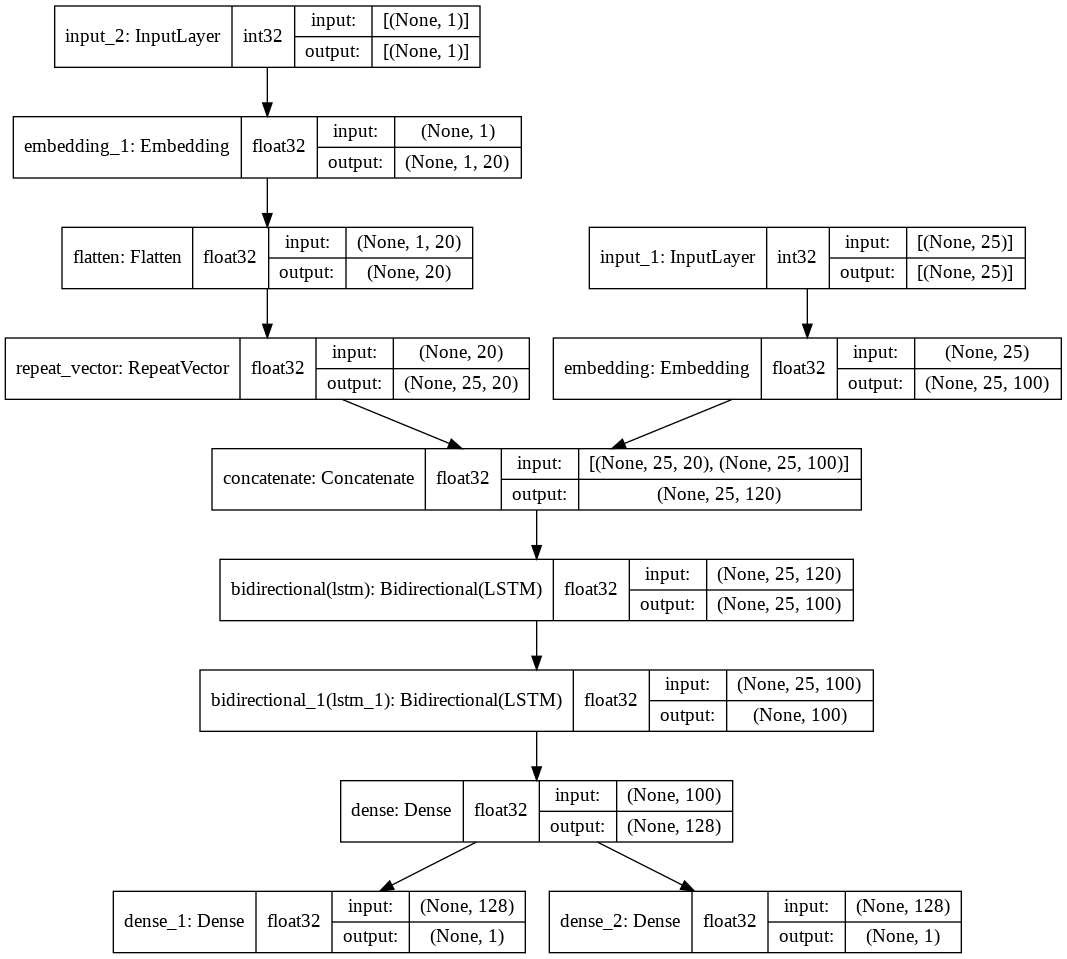

In [ ]:
tensorflow.keras.utils.plot_model(model, "BIR.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

#Train

In [ ]:
model.fit([x_train,labels_train], [y_train_i,y_train_f], validation_data=([x_val,labels_val], [y_val_i,y_val_f]),
          epochs=15, batch_size=32,verbose=1)

loss, loss1, loss2, MAE1,MSE1,MAE2,MSE2 = model.evaluate([x_test,labels_test],[y_test_i,y_test_f], verbose=0,batch_size=128)
print("Loss: {}".format(loss))
print("MAE 1: {} MAE 2: {}".format(MAE1,MAE2))
#print('F1: %f' % (((2*recall*precision) / (recall + precision))*100))
print("MSE 1: {} MSE 2: {}".format(MSE1,MSE2))

#Validación modelo 1

In [ ]:
predi,predf = model.predict([x_test,labels_test])

se realiza un test de comparación entre la predicción y la variable objetivo

In [ ]:
a = 222
print(predi[a],predf[a])
print(y_test_i[a],y_test_f[a])

[0.47852674] [3.6666148]
0.0 5.0


#Decodificación

In [ ]:
def redondeo(x):
  l = []
  for i in x:
    a = round(i[0],0)
    if a < 0:
      a = 0
    l.append(a)
  return np.array(l,dtype='float32')

In [ ]:
y_pred_i = redondeo(predi)
y_pred_f = redondeo(predf)

In [ ]:
y_pred_i.shape ,y_pred_f.shape

((4122,), (4122,))

In [ ]:
y_pred_i.shape,y_test_i.shape

((4122,), (4122,))

In [ ]:
a = 2000
print(predi[a],predf[a])
print(y_pred_i[a],y_pred_f[a])
print(y_test_i[a],y_test_f[a])

[1.7261335] [3.1269796]
2.0 3.0
0.0 1.0


In [ ]:
y_test_i = to_categorical(y_test_i)
y_test_f = to_categorical(y_test_f)
y_pred_i = to_categorical(y_pred_i)
y_pred_f = to_categorical(y_pred_f)

In [ ]:
y_pred_i.shape,y_pred_f.shape,y_test_i.shape, y_test_f.shape

((4122, 12), (4122, 17), (4122, 19), (4122, 22))

In [ ]:
def fill(x,y):
  l = []
  for c in range(x.shape[0]):
    inic = np.where(x[c]==1)[0][0]
    fin = np.where(y[c]==1)[0][0]
    uno = np.append(np.zeros(25)[:inic],1)
    dos = np.concatenate((uno,np.ones((fin-inic))))
    r = np.concatenate((dos,(np.zeros(25-dos.shape[0]))))
    #res = np.concatenate((uno,tres),axis=0)
    #r = np.concatenate((res,tres),axis=0)
    l.append(r)
  return np.array(l)

In [ ]:
y_pred = fill(y_pred_i,y_pred_f)
y_test = fill(y_test_i,y_test_f)

In [ ]:
y_pred.shape

(4122, 25)

In [ ]:
y_test.shape

(4122, 25)

#MÉTRICAS

##Accuracy

In [ ]:
p = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l]:
      p = p + 1
print(p / (y_test.shape[0]*y_test.shape[1]),p)

0.9161475012130034 94409


##Presicion

In [ ]:
fp = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.7596769541390251


##Recall

In [ ]:
fn = 0
tp = 0
for n in range(y_test.shape[0]):
  for l in range(y_test[n].shape[0]):
    if y_test[n][l] == y_pred[n][l] and y_pred[n][l] == 1:
      tp = tp + 1
    if y_test[n][l] != y_pred[n][l] and y_pred[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.746372704602131


In [ ]:
print('recall:{}'.format(recall_m(y_test,y_pred)))
print('precision:{}'.format(precision_m(y_test,y_pred)))
print('F1:{}'.format(f1_m(y_test,y_pred)))

recall:0.7463727045979008
precision:0.7596769541346428
F1:0.7529660153530977


Funciones para remover el padding

In [ ]:
def withoutpadding(x,y):
  f = []
  for k,i in enumerate(x):
    a = i[:y[k]]
    f.append(a)
  return np.array(f)

In [ ]:
def withoutpadding2(x,y):
  f = []
  for i in range(x.shape[0]):
    a = x[i][:y[i]]
    f.append(a)
  return np.array(f)

In [ ]:
y_test_p = withoutpadding(y_test,long_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
y_test_t = withoutpadding2(y_test,long_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
y_pred_p = withoutpadding2(y_pred,long_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
type(y_test_p)

numpy.ndarray

In [ ]:
y_pred_p.shape, y_test_p.shape

((4122,), (4122,))

In [ ]:
y_test[0][:long_test[0]]

array([1., 1., 1., 1.])

##Presicion sin padding

In [ ]:
fp = 0
tp = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    #if y_test[n][l] == 1:
      #tp = tp + 1
    if y_test_t[n][l] == y_pred_p[n][l] and y_pred_p[n][l] == 1:
      tp = tp + 1
    if y_test_t[n][l] != y_pred_p[n][l] and y_pred_p[n][l] == 1:
      fp = fp + 1 


print(tp/(tp+fp))

0.7836003096528316


##Accuracy sin padding

In [ ]:
p = 0
count = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    count = count + 1
    if y_test_t[n][l] == y_pred_p[n][l]:
      p = p + 1
print(p / count)

0.7374370635049537


##Recall sin padding

In [ ]:
fn = 0
tp = 0
for n in range(y_test_t.shape[0]):
  for l in range(y_test_t[n].shape[0]):
    if y_test_t[n][l] == y_pred_p[n][l] and y_pred_p[n][l] == 1:
      tp = tp + 1
    if y_test_t[n][l] != y_pred_p[n][l] and y_pred_p[n][l] == 0:
      fn = fn + 1 


print(tp/(tp+fn))

0.7525568181818182


##Jaccard

In [ ]:
text_true = list(ts_test)

Función dec jaccard

In [ ]:
def decjac(a,b):
  op=[]
  for i,j in enumerate(a):
    if j == 1:
      op.append(b.split()[i])
  return " ".join(op)

In [ ]:
j_test=[]
for ki in range(len(text_true)):
  j_test.append(decjac(y_test_t[ki],text_true[ki]))

In [ ]:
j_pred=[]
for kp in range(len(text_true)):
  j_pred.append(decjac(y_pred_p[kp],text_true[kp]))

In [ ]:
j_pred


In [ ]:
def jaccard(str1, str2):
    if len(str1) == 0 and len(str2) == 0:
      return 0.0
    else:
      a = set(str1.lower().split()) 
      b = set(str2.lower().split())
      c = a.intersection(b)
      return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
rest2 = [jaccard(j_test[i],j_pred[i]) for i in range(len(j_test))]

In [ ]:
print("el promedio de jaccard es: {}".format(sum(rest2)/len(rest2)))

el promedio de jaccard es: 0.5580826585839241
